In [1]:
%load_ext autoreload
%autoreload 2

import math

import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix, roc_auc_score
from sklearn.utils import compute_class_weight,shuffle

import scipy.stats

import seaborn as sns

print(tf.test.is_built_with_cuda())
gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

from config import img_size, batch_size, model_path
from utils import round_by_threshold

from ipywidgets import interact
import ipywidgets as widgets

import IPython.display


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the data

In [2]:
def load_data(val_split=0.1, test_split=0.1, undersample=False):
    df = pd.read_csv("data/HAM10000_metadata.csv")
    df["label"] = df["dx"].apply(lambda dx: "malignant" if dx in ["akiec", "bcc", "mel"] else "benign") 
    #https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf
    df["image_id"] = df["image_id"].apply(lambda id: f"{id}.jpg")
    
    if undersample:
        df_benign = df[df["label"] == "benign"]
        df_malignant = df[df["label"] == "malignant"]
        df = pd.concat([df_benign.sample(n=len(df_malignant), random_state=0), df_malignant])
    
    # shuffle data
    df = df.sample(frac=1, random_state=0, replace=False)
    #df = shuffle(df)
    
    data_size = len(df)
    
    val_size = math.floor(data_size * val_split)
    test_size = math.floor(data_size * test_split)
    
    train_cutoff = data_size - val_size - test_size
    val_cutoff = train_cutoff + val_size
    
    training_df = df[:train_cutoff]
    validation_df = df[train_cutoff:val_cutoff]
    testing_df = df[val_cutoff:]

    classes=["benign", "malignant"]
    
    training_data_generator = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.95, 1.05],
        zoom_range=[0.85, 1.15]
    )

    validation_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    testing_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    training_data = training_data_generator.flow_from_dataframe(
        dataframe= training_df,
        directory="data/images_cropped",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="binary",
        classes=classes,
        shuffle=True,
        
    )

    validation_data = validation_data_generator.flow_from_dataframe(
        dataframe=validation_df,
        directory="data/images_cropped",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="binary",
        classes=classes,
        shuffle=True
    )

    test_data = testing_data_generator.flow_from_dataframe(
        dataframe=testing_df,
        directory="data/images_cropped",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        class_mode="binary",
        classes=classes,
        batch_size=1015,
        shuffle=False
    )

    return training_data, validation_data, test_data

### Creating the model
Explanation of why the model looks like it does

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Model



def create_model():
    #model = Sequential()
    #model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    #model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    #model.add(layers.Flatten())
    #model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dense(7, activation='softmax'))

    #model =  Sequential()
    #model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=(img_size, img_size, 3)))
    #model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='valid'))
    #model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    #model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.Flatten())
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dense(1, activation='sigmoid'))
    
    
    
    model = InceptionV3(
        input_shape=(img_size, img_size, 3), pooling="max", include_top=True, classes=1, classifier_activation="sigmoid", weights=None
    )
    
    
    model.compile(optimizer='adam', loss=[BinaryCrossentropy(from_logits=False)], weighted_metrics=[AUC(name="auc",  curve='ROC'), BinaryAccuracy(name="accuracy")])

    return model

### Training the model

In [61]:
def train_model(model, training_data, validation_data, epochs=2, use_class_weight=True):
    
    model_checkpoint_callback = ModelCheckpoint(
        filepath=model_path,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    csv_logger = CSVLogger(f'{model_path}/history.csv', append=False)
    
    # Automatically compute class weights based on label percentage
    y_train = training_data.labels
    class_weight = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))) if use_class_weight else None
    print(f'Class weights: {class_weight}')
    
    history = model.fit(training_data, epochs=epochs, validation_data=validation_data, verbose=1, class_weight=class_weight, callbacks=[model_checkpoint_callback, csv_logger])
    return history

### Evaluate the model

In [62]:
def evaluate_model(model, test_data, threshold):
    y_true = test_data[0][1]
    x = test_data[0][0]
    y_score = model.predict(x)
    y_pred = [round_by_threshold(y[0], threshold) for y in y_score]
    
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred), roc_auc_score(y_true, y_score)

Comments on the results

In [63]:
def save_model(model, path):
    model.save(path)

### Putting it all together

In [64]:
model = create_model()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

 batch_normalization_99 (BatchN  (None, 35, 35, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 35, 35, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 35, 35, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 35, 35, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 35, 35, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 17, 17, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 17, 17, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 17, 17, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 17, 17, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 17, 17, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 17, 17, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 8, 8, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 8, 8, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 8, 8, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

In [66]:
training_data, validation_data, test_data = load_data()
training_result = train_model(model, training_data, validation_data, epochs=240, use_class_weight=False)

Found 8013 validated image filenames belonging to 2 classes.
Found 1001 validated image filenames belonging to 2 classes.
Found 1001 validated image filenames belonging to 2 classes.
Class weights: None
Epoch 1/240


KeyboardInterrupt: 

In [30]:
#save_model(model, model_path)

In [11]:
model = tf.keras.models.load_model(model_path)
training_data, validation_data, test_data = load_data()

Found 8013 validated image filenames belonging to 2 classes.
Found 1001 validated image filenames belonging to 2 classes.
Found 1001 validated image filenames belonging to 2 classes.


In [12]:
# convert the history.history dict to a pandas DataFrame:     
#hist_df = pd.DataFrame(training_result.history)

#hist_df.to_csv(f'./{model_path}/history.csv')

In [13]:
history = pd.read_csv(f'./{model_path}/history.csv')

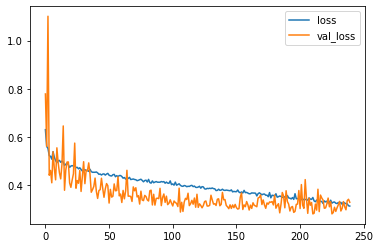

In [14]:
labels = ["loss", "val_loss"]
for label in labels:
     plt.plot(history[label])
plt.legend(labels)
plt.show()

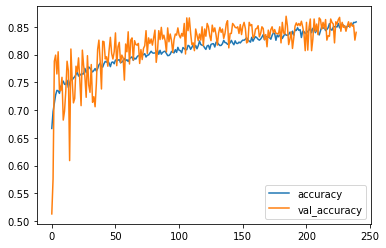

In [15]:
labels = ["accuracy", "val_accuracy"]
for label in labels:
    plt.plot(history[label])
plt.legend(labels)
plt.show()

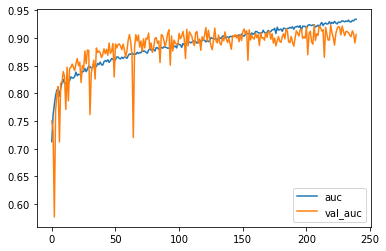

In [16]:
labels = ["auc", "val_auc"]
for label in labels:
    plt.plot(history[label])
plt.legend(labels)
plt.show()

In [48]:
def plot_cm(y_true, y_score, threshold=0.5):
    y_pred = [round_by_threshold(y, threshold) for y in y_score]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def plot_roc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    plt.figure(figsize=(8,8))
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='model')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.title(f'Receiver operating characteristic (ROC) with {round(roc_auc_score(y_true, y_score), 3)} AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    
def plot_prediction_distributions(y_true, y_score, threshold):
    test_y = y_true
    predicted_y_probs = y_score

    def estimate_beta(X):
        xbar = np.mean(X)
        vbar = np.var(X,ddof=1)
        alphahat = xbar*(xbar*(1-xbar)/vbar - 1)
        betahat = (1-xbar)*(xbar*(1-xbar)/vbar - 1)
        return alphahat, betahat

    positive_beta_estimates = estimate_beta(predicted_y_probs[test_y == 1])
    negative_beta_estimates = estimate_beta(predicted_y_probs[test_y == 0])

    fig, ax = plt.subplots(1, 2, figsize=(15,8))
    
    unit_interval = np.linspace(0,1,100)
    ax[0].plot(unit_interval, scipy.stats.beta.pdf(unit_interval, *positive_beta_estimates), c='r', label="malignant")
    ax[0].plot(unit_interval, scipy.stats.beta.pdf(unit_interval, *negative_beta_estimates), c='g', label="benign")

    # Show the threshold.
    ax[0].axvline(threshold, c='black', ls='dashed')
    ax[0].set_xlim(0,1)
    ax[0].set_yticks([], [])

    # Add labels
    ax[0].legend()
    
    # Actual
    n_bins = 10
    benigns = np.zeros(n_bins + 1)
    malignants = np.zeros(n_bins + 1)

    for i in range(len(y_true)):
        if (y_true[i] == 0):
            benigns[int(y_score[i] * n_bins)] += 1
        else:
            malignants[int(y_score[i] * n_bins)] += 1


    # plt.plot(xs, y1s)
    # plt.plot(xs, y2s)
    ax[1].plot(np.array(range(n_bins + 1)) * 1.0 / n_bins, benigns, c='g')
    ax[1].plot(np.array(range(n_bins + 1)) * 1.0 / n_bins, malignants,  c='r')
    
    ax[1].axvline(threshold, c='black', ls='dashed')
    ax[1].set_xlim(0,1)

    ax[1].legend(["Benign", "Malignant"])
    ax[1].set_xlabel("% malignant")
    # plt.ylabel("Score")
    plt.show()

    

In [49]:
y_true = test_data[0][1]
x = test_data[0][0]
y_score = model.predict(x)


Best Threshold=0.197708, G-Mean=0.829


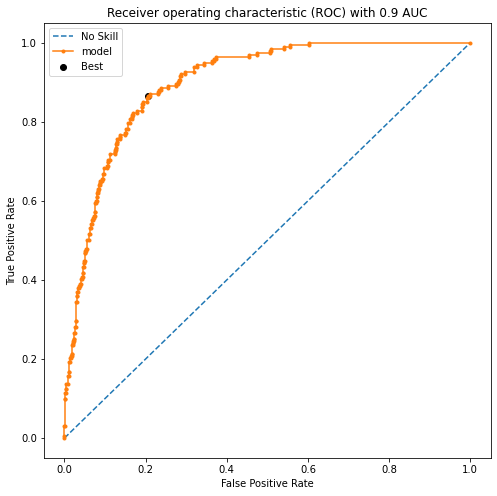

In [50]:
plot_roc(y_true, y_score)

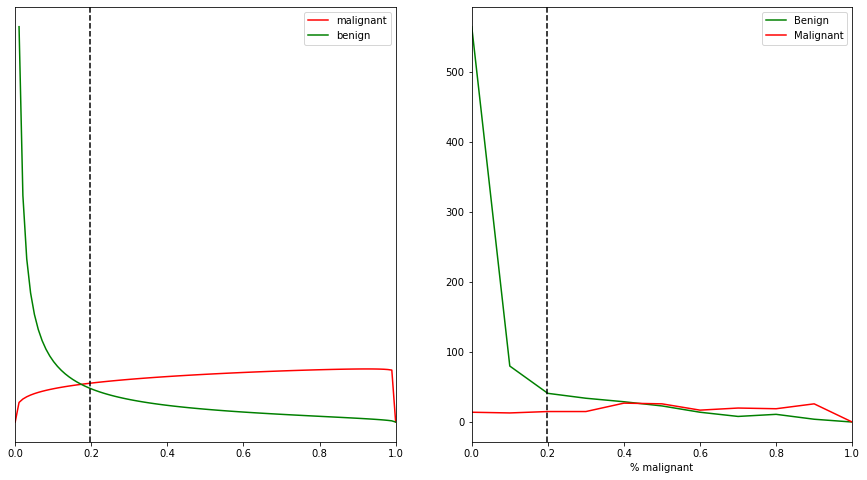

In [51]:
plot_prediction_distributions(y_true, y_score, 0.197710)

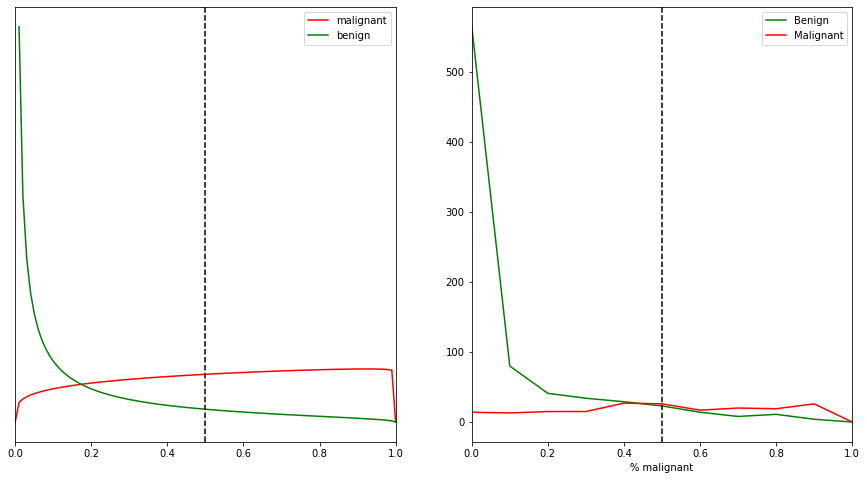

In [52]:
plot_prediction_distributions(y_true, y_score, 0.5)

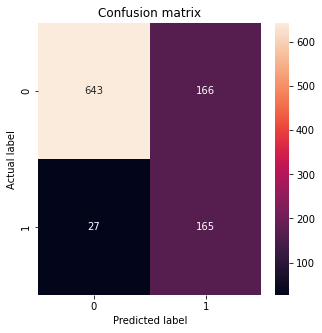

In [53]:
# Confusion matrix when using the best threshold
plot_cm(y_true, y_score, 0.197710)

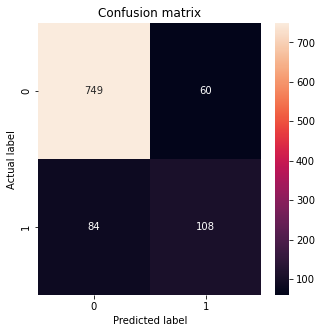

In [54]:
# Confusion matrix when using default 0.5 as threshold
plot_cm(y_true, y_score, 0.5)

In [55]:
test_result = evaluate_model(model, test_data, 0.197710)
print(f"Accuracy: {test_result[0]}")
print(f"F1-score: {test_result[1]}")
print(f"ROC AUC: {test_result[2]}")


Accuracy: 0.8071928071928072
F1-score: 0.6309751434034417
ROC AUC: 0.8995866810877627


In [56]:
test_result = evaluate_model(model, test_data, 0.5)
print(f"Accuracy: {test_result[0]}")
print(f"F1-score: {test_result[1]}")
print(f"ROC AUC: {test_result[2]}")

Accuracy: 0.8561438561438561
F1-score: 0.6000000000000001
ROC AUC: 0.8995866810877627


In [57]:
def show_f1(threshold):
    y_pred = [round_by_threshold(y, threshold) for y in y_score]
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"F1-score: {f1_score(y_true, y_pred)}")
    plot_cm(y_true, y_pred)

In [58]:
interact(show_f1, threshold=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_claâ€¦

<function __main__.show_f1(threshold)>

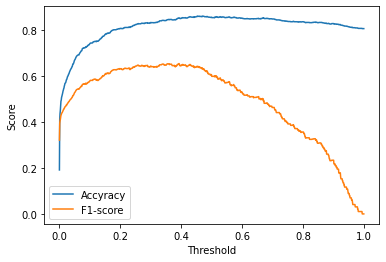

In [60]:
xs = []
accs = []
f1s = []

for i in range(0, 1000):
    x = i / 1000.0
    y_pred = [round_by_threshold(y, x) for y in y_score]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    xs.append(x)
    accs.append(acc)
    f1s.append(f1)

plt.plot(xs, accs)
plt.plot(xs, f1s)
plt.legend(["Accuracy", "F1-score"])
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

(299, 299, 3)


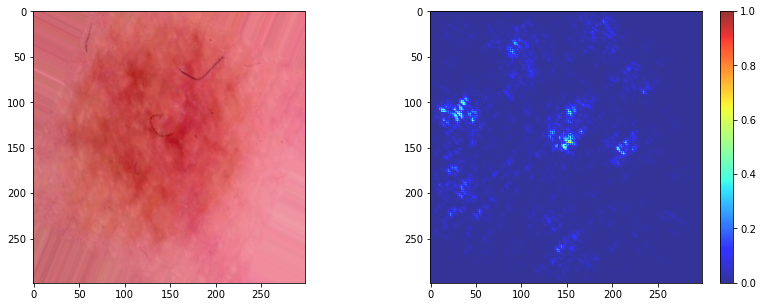

In [28]:
print(training_data[0][0][0].shape)
img = training_data[0][0][0]


images = tf.Variable(np.expand_dims(img, axis=0), dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

dgrad_abs = tf.math.abs(grads)

dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].imshow(img)
i = ax[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)